Using device: mps
Classes: ['benign', 'malignant']


/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma-env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma-env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


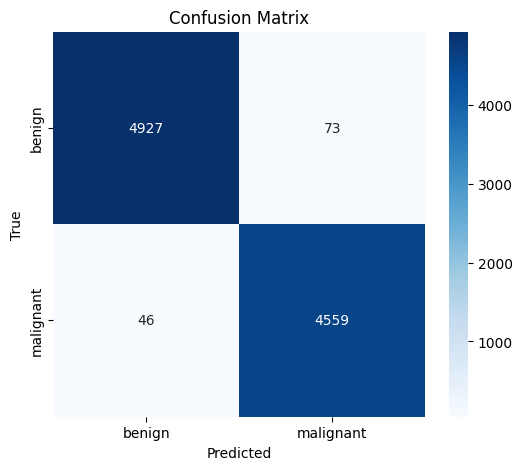


Classification Report:
              precision    recall  f1-score   support

      benign       0.99      0.99      0.99      5000
   malignant       0.98      0.99      0.99      4605

    accuracy                           0.99      9605
   macro avg       0.99      0.99      0.99      9605
weighted avg       0.99      0.99      0.99      9605


✅ Results exported to: /Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/results.json


In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# === CONFIG ===
VALIDATION_DIR = '/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/data/validation/train'
MODEL_PATH = '/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma_model.pth'
BATCH_SIZE = 32
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# === TRANSFORMS ===
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === LOAD DATA ===
test_dataset = datasets.ImageFolder(VALIDATION_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = test_dataset.classes  # ['benign', 'malignant']
print(f"Classes: {class_names}")

# === LOAD MODEL ===
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, len(class_names))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# === EVALUATION ===
all_preds = []
all_labels = []
all_confs = []
all_paths = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_confs.extend(confs.cpu().numpy())

# === CONFUSION MATRIX ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# === CLASSIFICATION REPORT ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# === EXPORT RESULTS TO JSON ===
results = []
for i in range(len(all_preds)):
    results.append({
        "true_label": class_names[all_labels[i]],
        "predicted_label": class_names[all_preds[i]],
        "confidence": float(all_confs[i])
    })

output_path = os.path.join(os.getcwd(), "results.json")
with open(output_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"\n✅ Results exported to: {output_path}")

In [7]:
import os

train_files = set(os.listdir('data/train/benign')) | set(os.listdir('data/train/malignant'))
val_files = set(os.listdir('data/validation/test/benign')) | set(os.listdir('data/validation/test/malignant'))

print(len(train_files & val_files))  # should be 0

0


In [10]:
import os

def get_all_filenames(folder):
    files = []
    for root, _, filenames in os.walk(folder):
        for f in filenames:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                files.append(f)
    return set(files)

train_files = get_all_filenames('/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/data/train')
val_files = get_all_filenames('/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/data/validation/train')

overlap = train_files & val_files
print(f"Overlap: {len(overlap)} files")

Overlap: 0 files
